# $\rho'$ analysis notes

### Data scheme

In [2]:
# from importlib import reload
# reload(modules.info.DataInfo)
from modules.data.info.DataInfo import DataInfo, tree
DataInfo()
#data.nTracks

RunNum                     (no streamer)              asdtype('>i4')
PeriodNumber               (no streamer)              asdtype('>u4')
OrbitNumber                (no streamer)              asdtype('>u4')
BunchCrossNumber           (no streamer)              asdtype('>u2')
Mass                       (no streamer)              asdtype('>f4')
Pt                         (no streamer)              asdtype('>f4')
Q                          (no streamer)              asdtype('>i2')
Rapidity                   (no streamer)              asdtype('>f4')
Phi                        (no streamer)              asdtype('>f4')
ZNAenergy                  (no streamer)              asdtype('>f4')
ZNCenergy                  (no streamer)              asdtype('>f4')
ZPAenergy                  (no streamer)              asdtype('>f4')
ZPCenergy                  (no streamer)              asdtype('>f4')
VtxX                       (no streamer)              asdtype('>f4')
VtxY                       (no str

### Run numbers from 2015o period

245345 8
245407 4
245705 5
245793 9
246001 5
246181 6
246217 9
246222 6
246844 23
246864 10
246989 15


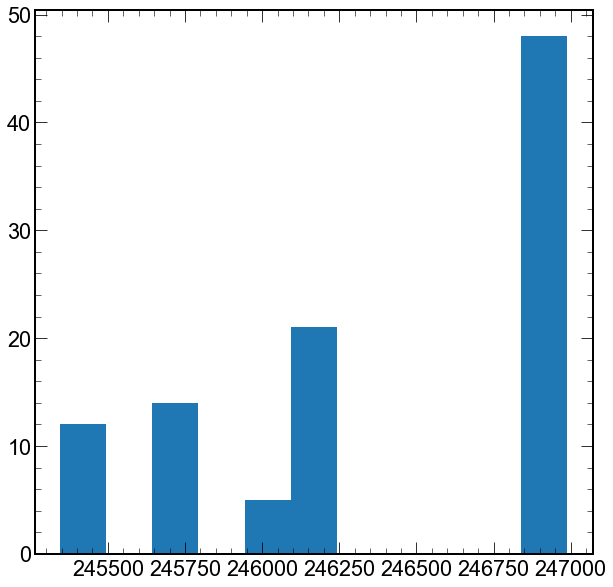

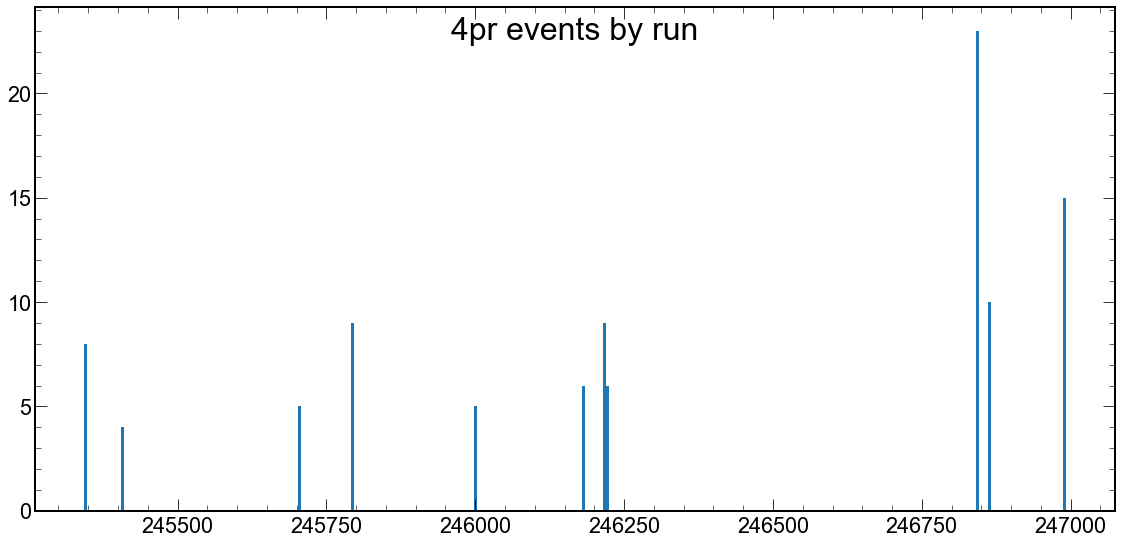

In [23]:
# from modules.data.info.RunsInfo import ShowRunsInfo
# from importlib import reload
reload(modules.data.info.RunsInfo)
ShowRunsInfo()



## Selection criteria:

These criteria were applied on the selection stage:

Events:

    * Zero cumulative charge 
    * at least four tracks satisfy track selection criteria.
    
Tracks:

    * Has Point On inner or outer ITS Layer
    * dca1 < 2 and dca0 < (0.0182 + 0.0350 / TMath::Power(trk->Pt(), 1.01));

## Analysis criteria:

These criteria will apply for the selected data:

    * numbers of ITS clusters more then 3
    * not ITS SA

Only ITS reconstructed particles have small energies. We [have see](https://github.com/bdrum/cern-physics/issues/21) it on the such parameters like p, pt, $\theta$ 


In [5]:
from modules.data.selection.tracks import selectedTracksMask, selectedTracksWithTpcMask

## Kinematics

![img1](https://sun9-40.userapi.com/89LOl8xefEwIdRLprtnxyAO3hkP8phFVEXMRMw/O-murEnPIMM.jpg)


### Transversal momentum (pt)


[0.49860728 0.20050775 0.23176081 0.3374393 ]
[0.20050775 0.23176081 0.3374393 ]
[0.49860728]


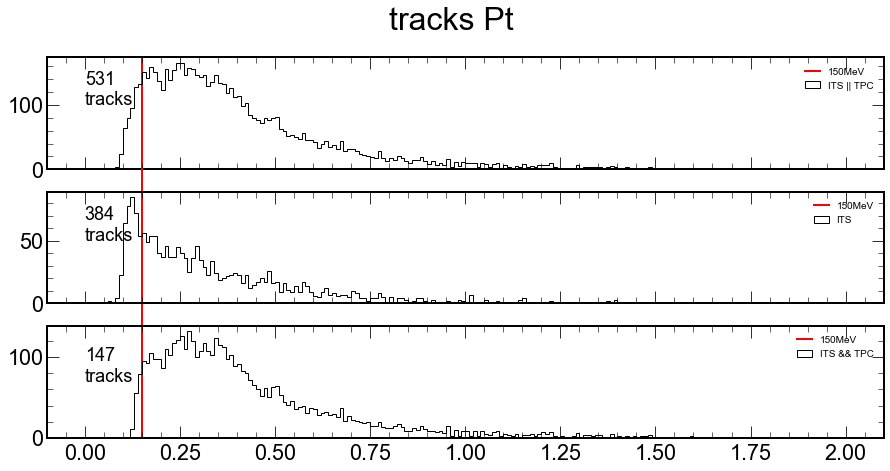

In [31]:
from modules.physics.kinematics.momentum import GetPtTracks, GetPTracks, plt, hep, np
from modules.data.selection.tracks import selectedTracksMask, selectedTracksWithTpcMask
from modules.data.selection.events import GetGoodEventsNumbers
from modules.physics.kinematics.rapidity import GetTheta


GoodEventsITS = GetGoodEventsNumbers()
ptITSOrTPC = GetPtTracks(selectedTracksMask,GoodEventsITS).flatten()
# pITS = GetPTracks(selectedTracksMask, GoodEventsITS).flatten()
# thetaITS = GetTheta(selectedTracksMask, GoodEventsITS).flatten()

ptITS = GetPtTracks(selectedTracksMask*(~selectedTracksWithTpcMask),GoodEventsITS).flatten()

# GoodEventsTPC = GetGoodEventsNumbers(WithGoodNTpcTracks=4)
ptITSAnd4TPC = GetPtTracks(selectedTracksMask*selectedTracksWithTpcMask,GoodEventsITS).flatten() # GetPtTracks(selectedTracksWithTpcMask,GoodEventsTPC).flatten()
# pTPC = GetPTracks(selectedTracksWithTpcMask, GoodEventsTPC).flatten()
# thetaTPC = GetTheta(selectedTracksWithTpcMask, GoodEventsTPC).flatten() 

plt.style.use(hep.style.ROOT)
# _ = plt.hist(ptITS,alpha=0.5, bins=200, range=(0,2), color='black', histtype='step')
# _ = plt.hist(ptTPC,alpha=0.5, bins=200, range=(0,2), color='red', histtype='step')


fig, axs = plt.subplots(3, figsize=(15,7), sharex=True)

fig.suptitle(f'tracks Pt', fontsize=32)
axs[0].hist(ptITSOrTPC, bins=200, range=(0,2), color='black', histtype='step', label = 'ITS || TPC')
axs[0].axvline(x=0.15,ymin=0,ymax=1,c="red",linewidth=2, zorder=0,clip_on=False,label='150MeV')
axs[0].legend(prop={'size': 10})
axs[0].text(0, 100, f"{len(ptITSOrTPC[ptITSOrTPC<0.15])}\ntracks", size=18)

axs[1].hist(ptITS, bins=200, range=(0,2), color='black', histtype='step', label=f'ITS')
axs[1].axvline(x=0.15,ymin=-1.2,ymax=1.2,c="red",linewidth=2,zorder=0, clip_on=False,label='150MeV')
axs[1].legend(prop={'size': 10})
axs[1].text(0, 50, f"{len(ptITS[ptITS<0.15])}\ntracks", size=18)

axs[2].hist(ptITSAnd4TPC, bins=200, range=(0,2), color='black', histtype='step', label=f'ITS && TPC')
axs[2].axvline(x=0.15,ymin=0,ymax=1,c="red",linewidth=2,zorder=0, clip_on=False,label='150MeV')
axs[2].legend(prop={'size': 10})
axs[2].text(0, 70, f"{len(ptITSAnd4TPC[ptITSAnd4TPC<0.15])}\ntracks", size=18)

# x=x[np.where(y == y.max())]

# fig, axs = plt.subplots(2, figsize=(15,7), sharex=True)
# axs[0].hist(pITS, bins=200, range=(0,2), color='black', histtype='step')
# axs[0].set_title('P ITS only')
# axs[1].hist(pTPC, bins=200, range=(0,2), color='red', histtype='step')
# axs[1].set_title('P ITS+TPC')
# axs[0].axvline(x=0.25,ymin=-1.2,ymax=1,c="red",linewidth=2,zorder=0, clip_on=False)
# axs[1].axvline(x=0.25,ymin=0,ymax=1.2,c="red",linewidth=2, zorder=0,clip_on=False)

# fig, axs = plt.subplots(2, figsize=(15,7), sharex=True)
# axs[0].hist(thetaITS.flatten(), bins=360, range=(0,3), color='black', histtype='step')
# axs[0].set_title('Theta ITS only')
# axs[1].hist(thetaTPC.flatten(), bins=360, range=(0,3), color='red', histtype='step')
# axs[1].set_title('Theta ITS+TPC')
# axs[0].axvline(x=0.75,ymin=-1.2,ymax=1,c="red",linewidth=2,zorder=0, clip_on=False)
# axs[1].axvline(x=0.75,ymin=0,ymax=1.2,c="red",linewidth=2, zorder=0,clip_on=False)


# Zero charge vs Non zero charge
# plt.style.use(hep.style.ROOT)
# fig = plt.figure(figsize=(14, 7))
# ax = fig.add_axes([-1, 0, 1, 1])
# fig.suptitle(f'3pr Pt | NonZero Charge vs Zero Charge', fontsize=32)
# plt.style.use(hep.style.ROOT)
# GoodEvents = GetGoodEventsNumbers()
# ptzq = GetPt(selectedTracksMask, GoodEvents,Draw=False)
# counts, bins = np.histogram(ptzq, bins=99, range=(0, 2))
# _ = ax.hist(ptzq, bins=bins, color='black', histtype='step',
#             label=f'Q = -1;Entries {np.sum(counts)}')
# GoodEvents = GetGoodEventsNumbers(ChargeEqualCondition=False)
# ptnzq = GetPt(selectedTracksMask, GoodEvents, Draw=False, ChargeEqualCondition=False)
# counts, bins = np.histogram(ptnzq, bins=99, range=(0, 2))
# _ = ax.hist(ptnzq, bins=bins, color='red', histtype='step',
#             label=f'Q != -1;Entries {np.sum(counts)}')
# plt.xlabel('Pt, GeV')
# plt.ylabel('# events')
# ax.legend()
print(GetPtTracks(selectedTracksMask,GoodEventsITS)[1])
print(GetPtTracks(selectedTracksMask*(~selectedTracksWithTpcMask),GoodEventsITS)[1])
print(GetPtTracks(selectedTracksMask*selectedTracksWithTpcMask,GoodEventsITS)[1])



In [7]:
from modules import tree,events
from modules.data.info.DataInfo import ShowTracksInEvent
from modules.data.selection.tracks import selectedTracksMask, selectedTracksWithTpcMask
from modules.data.selection.events import GetGoodEventsNumbers
from modules.physics.kinematics.momentum import GetPtTracks, GetPTracks, plt, hep, np, GetPtEvents

GoodEventsITS = GetGoodEventsNumbers()

# px = tree.T_Px[selectedTracksMask*(~selectedTracksWithTpcMask)][GoodEventsITS]
# py = tree.T_Px[selectedTracksMask*(~selectedTracksWithTpcMask)][GoodEventsITS]
print(GoodEventsITS[:10])

print(GetPtTracks(selectedTracksMask,GoodEventsITS)[1])
ShowTracksInEvent(27)



[21 27 39 46 66 73 76 80 81 85]
[0.49860728 0.20050775 0.23176081 0.3374393 ]


Selected  T_Q      T_Px      T_Py      T_Pz      T_Pt  \
entry subentry                                                          
27    0             True   -1 -0.480419 -0.133443 -0.279350  0.498607   
      1             True    1  0.189632 -0.065140 -0.061062  0.200508   
      2             True   -1  0.209156 -0.099833 -0.331999  0.231761   
      3             True    1  0.011256  0.337252 -0.361656  0.337439   

                    E_Pt  T_TPCNCls  T_ITSNCls  T_TPCRefit  T_ITSRefit  \
entry subentry                                                           
27    0         0.080379        146          5        True        True   
      1         0.080379          0          6       False        True   
      2         0.080379          0          6       False        True   
      3         0.080379          0          5       False        True   

                RunNum  PeriodNumber  OrbitNumber  BunchCrossNumber    T_Dca1  \
entry subentry                                                                  
27    0         246844             1      5990493              2054  0.009469   
      1         246844             1      5990493              2054  0.029379   
      2         246844             1      5990493              2054  0.013828   
      3         246844             1      5990493              2054 -0.036087   

                  T_Dca0  T_NumberOfSigmaTPCPion  
entry subentry                                    
27    0        -0.025019               -0.355273  
      1        -0.028290             -999.000000  
      2         0.001087             -999.000000  
      3        -0.007915             -999.000000

## Mass

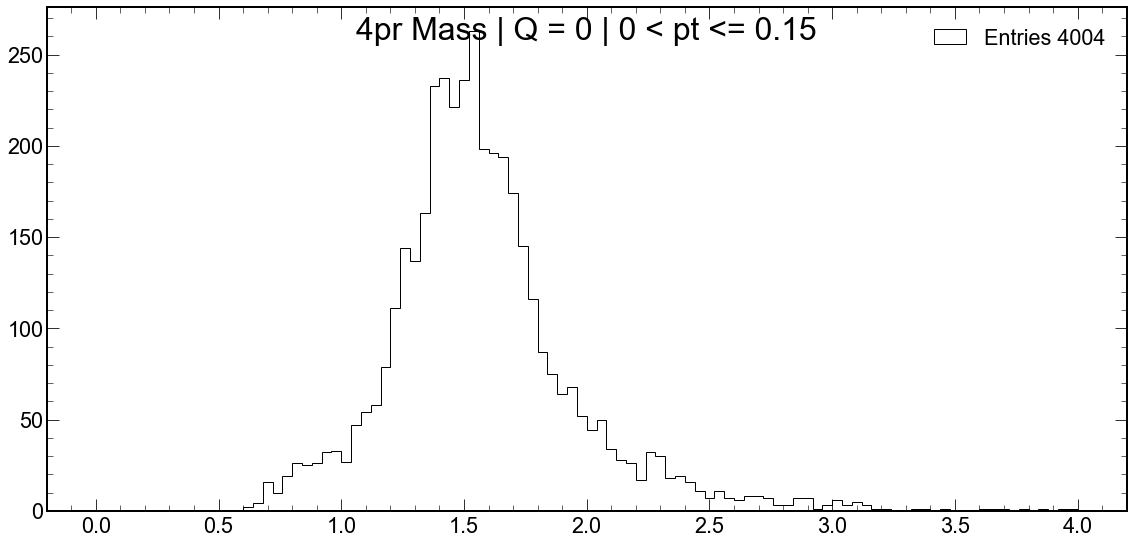

In [41]:
def GetMass(ptMin=0, ptMax=0.15, Draw=True, ChargeEqualCondition=True):
    pxg = data['T_Px'][select][GoodEvents]
    pyg = data['T_Py'][select][GoodEvents]
    pzg = data['T_Pz'][select][GoodEvents]
    massPion = np.full(pxg.shape[0], 0.140)
    pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)

    Energy0 = np.sqrt(massPion**2 + pxg[:,0]**2 + pyg[:,0]**2 + pzg[:,0]**2)
    Energy1 = np.sqrt(massPion**2 + pxg[:,1]**2 + pyg[:,1]**2 + pzg[:,1]**2)
    Energy2 = np.sqrt(massPion**2 + pxg[:,2]**2 + pyg[:,2]**2 + pzg[:,2]**2)
    Energy3 = np.sqrt(massPion**2 + pxg[:,3]**2 + pyg[:,3]**2 + pzg[:,3]**2)

    Energy = Energy0 + Energy1 + Energy2 + Energy3
    
    Mass = np.sqrt(Energy**2 - pxg.sum()**2 - pyg.sum()**2 - pzg.sum()**2)[(pt>ptMin)*(pt<=ptMax)]
    
    if Draw:
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_axes([0,0,1,1])
        if ChargeEqualCondition:
            fig.suptitle(f'4pr Mass | Q = 0 | {ptMin} < pt <= {ptMax}', fontsize=32)
        else:
            fig.suptitle(f'4pr Mass | Q != 0 | {ptMin} < pt <= {ptMax}', fontsize=32)
        plt.style.use(hep.style.ROOT)
        counts, bins = np.histogram(Mass, bins=100, range=(0,4))
        _ = ax.hist(Mass, bins=bins, color='black', histtype='step', label=f'Entries {np.sum(counts)}')
        ax.legend()
    else:
        return Mass
GoodEvents = GetGoodEvents()     
GetMass()

## Mass - pt - charge distirbution

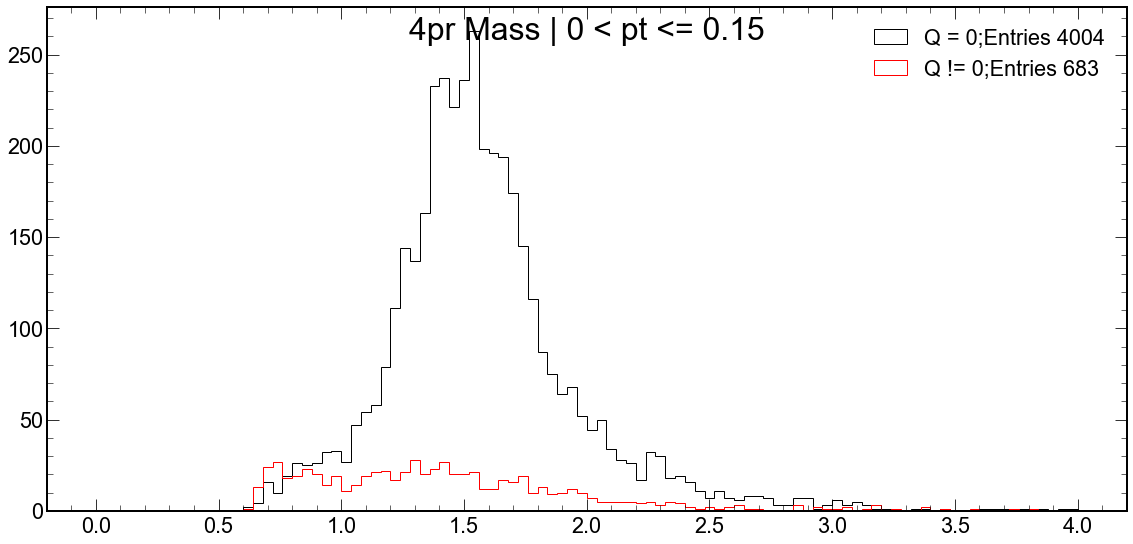

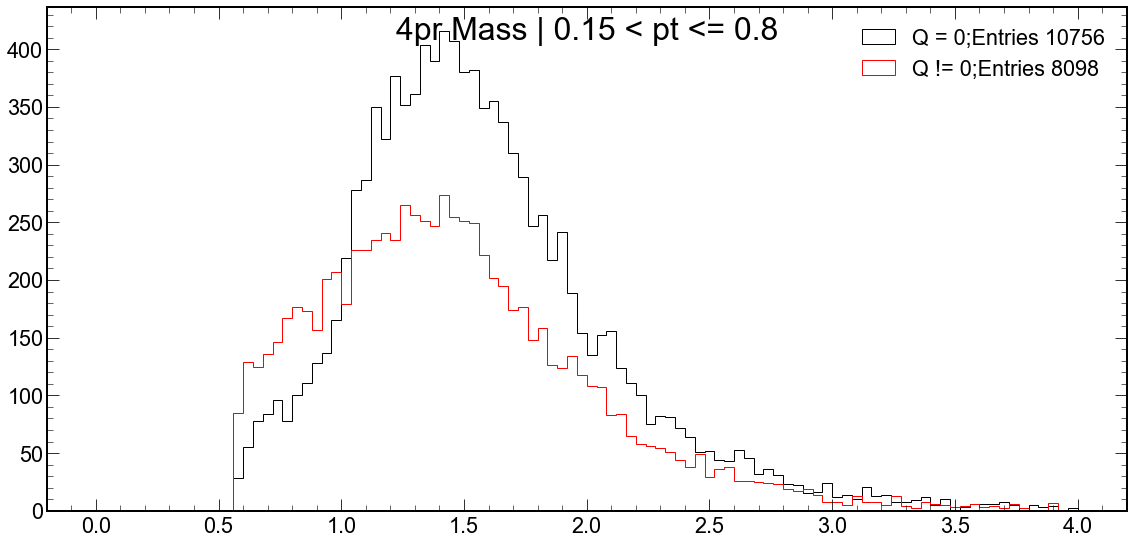

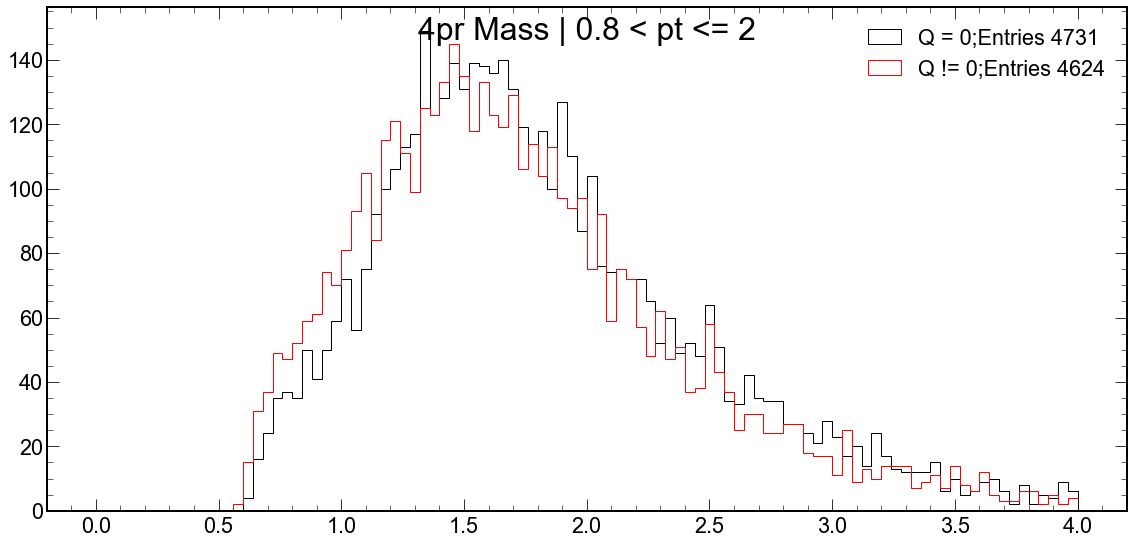

In [45]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0} < pt <= {0.15}', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetMass(Draw=False), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0.15} < pt <= {0.8}', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetMass(Draw=False, ptMin=0.15, ptMax=0.8), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False,ptMin=0.15, ptMax=0.8), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.15, ptMax=0.8), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.15, ptMax=0.8), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0.8} < pt <= {2}', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetMass(Draw=False, ptMin=0.8, ptMax=2), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False,ptMin=0.8, ptMax=2), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.8, ptMax=2), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.8, ptMax=2), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()



## Estimation of TPC influence


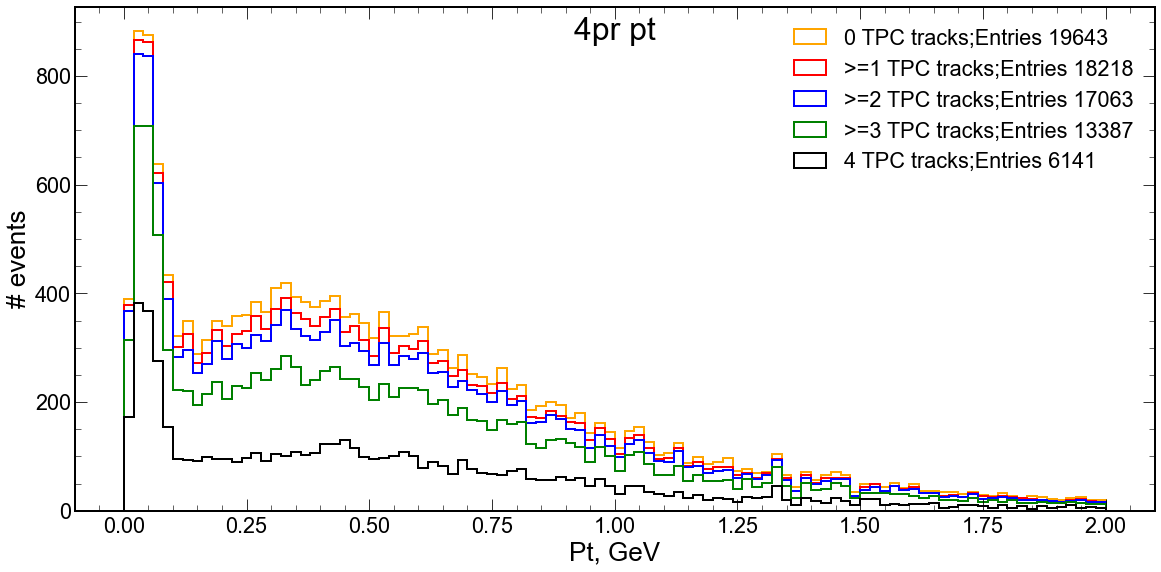

In [42]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr pt', fontsize=32)
plt.style.use(hep.style.ROOT)

GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='orange', histtype='step', label=f'0 TPC tracks;Entries {np.sum(counts)}', linewidth=2)

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=1)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='red', histtype='step', label=f'>=1 TPC tracks;Entries {np.sum(counts)}', linewidth=2)

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=2)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='blue', histtype='step', label=f'>=2 TPC tracks;Entries {np.sum(counts)}', linewidth=2)

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=3)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='green', histtype='step', label=f'>=3 TPC tracks;Entries {np.sum(counts)}', linewidth=2)

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=4)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='black', histtype='step', label=f'4 TPC tracks;Entries {np.sum(counts)}', linewidth=2)
plt.xlabel('Pt, GeV')
plt.ylabel('# events')
ax.legend()

## Energy losses

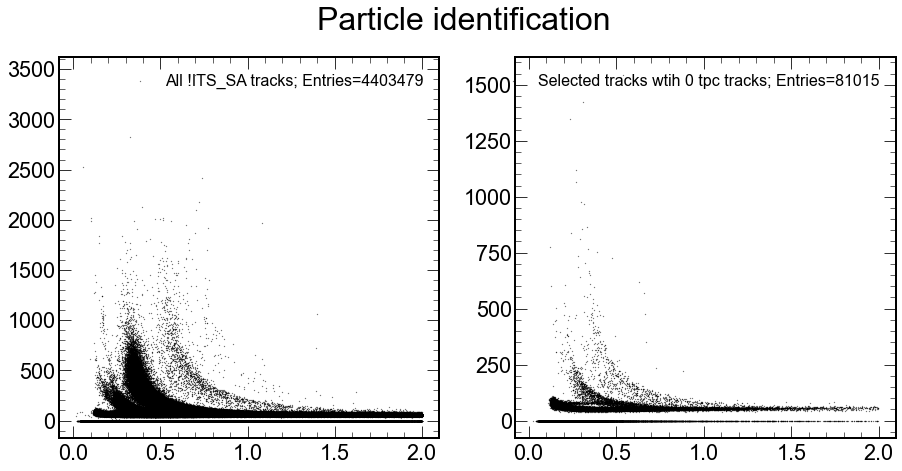

In [49]:
pt = np.sqrt(data['T_Px']**2 + data['T_Py']**2)
dedx = data['TPCsignal'][(pt<2)].flatten()
pt = pt[pt<2].flatten()

fig, ax = plt.subplots(1,2,figsize=(15, 7))
fig.suptitle(f'Particle identification', fontsize=32)
plt.style.use(hep.style.ROOT)
ax[0].scatter(pt, dedx, s=0.05, color='black', label=f'All !ITS_SA tracks; Entries={len(dedx)}')
ax[0].legend(loc=1, prop={'size': 16})

NTPCTracks = 0
GoodEvents = GetGoodEvents(WithGoodNTpcTracks=NTPCTracks)
ptTracks = np.sqrt(data['T_Px']**2 + data['T_Py']**2)[select][GoodEvents]
dedx = data['TPCsignal'][select][GoodEvents][ptTracks<2].flatten()
ptTracks = ptTracks[ptTracks<2]
ax[1].scatter(ptTracks.flatten(), dedx.flatten(), s=0.05, color = 'black',label=f'Selected tracks wtih {NTPCTracks} tpc tracks; Entries={len(dedx)}')
ax[1].legend(loc=1, prop={'size': 16})


# Debug

In [10]:
import pandas as pd

def ShowTracks(n, AllTracksInEvent=False):

    df = events.pandas.df(["T_Q", "T_P[xyz]", "*Cls", "*Refit", "RunNum", "PeriodNumber",\
                           "OrbitNumber","BunchCrossNumber", "T_Dca1", "T_Dca0", \
                           "T_NumberOfSigmaTPCPion"], entrystart=n, entrystop=n+1)
    
    df.insert(0, "Selected", select[n])
    pxg = data['T_Px'][select][n]
    pyg = data['T_Py'][select][n]
    
    pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)
    df.insert(4, "Pt", pt)

    if AllTracksInEvent:
        display(df)
    else:
        display(df[df['Selected']])

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=0)
print("Selected events list: \n", GoodEvents, len(GoodEvents))
n=27 #16385
ShowTracks(n, AllTracksInEvent=True)


Selected events list: 
 [    27     39     46 ... 114623 114635 114647] 17941


Selected  T_Q      T_Px      T_Py        Pt      T_Pz  \
entry subentry                                                          
27    0             True   -1 -0.480419 -0.133443  0.080379 -0.279350   
      1             True    1  0.189632 -0.065140  0.080379 -0.061062   
      2             True   -1  0.209156 -0.099833  0.080379 -0.331999   
      3             True    1  0.011256  0.337252  0.080379 -0.361656   

                T_TPCNCls  T_ITSNCls  T_TPCRefit  T_ITSRefit  RunNum  \
entry subentry                                                         
27    0               146          5        True        True  246844   
      1                 0          6       False        True  246844   
      2                 0          6       False        True  246844   
      3                 0          5       False        True  246844   

                PeriodNumber  OrbitNumber  BunchCrossNumber    T_Dca1  \
entry subentry                                                          
27    0                    1      5990493              2054  0.009469   
      1                    1      5990493              2054  0.029379   
      2                    1      5990493              2054  0.013828   
      3                    1      5990493              2054 -0.036087   

                  T_Dca0  T_NumberOfSigmaTPCPion  
entry subentry                                    
27    0        -0.025019               -0.355273  
      1        -0.028290             -999.000000  
      2         0.001087             -999.000000  
      3        -0.007915             -999.000000

## Valeri comparison

In [11]:
# Valeri data
valeri = pd.read_csv(r"D:\GoogleDrive\Job\cern\Alice\analysis\dev\pvn\log",header=None, delimiter=' ',  \
                     names=["RunNum", "PeriodNumber", "OrbitNumber", "BunchCrossNumber", "Pt"])
valeri



,RunNum,PeriodNumber,OrbitNumber,BunchCrossNumber,Pt
0,245683,3,10703439,1564,0.044254
1,245683,3,3228506,525,0.050910
2,245683,3,4050265,2311,0.139421
3,245683,3,2449154,19,0.054850
4,245683,3,15437718,1971,0.044654
...,...,...,...,...,...
2312,246994,3,4530108,552,0.036294
2313,246994,2,1128919,1353,0.033302
2314,246994,3,11883250,8,0.088530
2315,246994,1,9386270,989,0.020394


In [37]:
# my data
GoodEvents = GetGoodEvents()

pxg = data['T_Px'][GoodEvents]
pyg = data['T_Py'][GoodEvents]
pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)

RunNum = data['RunNum'][GoodEvents][pt<0.15]
PeriodNumber = data['PeriodNumber'][GoodEvents][pt<0.15]
OrbitNumber = data['OrbitNumber'][GoodEvents][pt<0.15]
BunchCrossNumber = data['BunchCrossNumber'][GoodEvents][pt<0.15]
dd = {"RunNum" : RunNum, "PeriodNumber":PeriodNumber, "OrbitNumber":OrbitNumber, "BunchCrossNumber":BunchCrossNumber}
myData = pd.DataFrame(dd)

pt = pt[pt<0.15]
myData.insert(4, "Pt", pt)
myData
print(len(pt))
myData

4013


,RunNum,PeriodNumber,OrbitNumber,BunchCrossNumber,Pt
0,246844,1,5990493,2054,0.080379
1,246989,3,15520459,1934,0.052750
2,246989,3,16608352,8,0.117275
3,246844,1,3312122,3556,0.037423
4,246087,11,9346043,2597,0.023912
...,...,...,...,...,...
4008,245543,2,10256560,2102,0.122794
4009,246846,1,554196,2645,0.118956
4010,246989,4,1150877,2090,0.022668
4011,245453,2,5433824,503,0.074020


245683 246994 1311
245145 246994 1849
Valeri good events number:  2317
Boris good events number:  2364


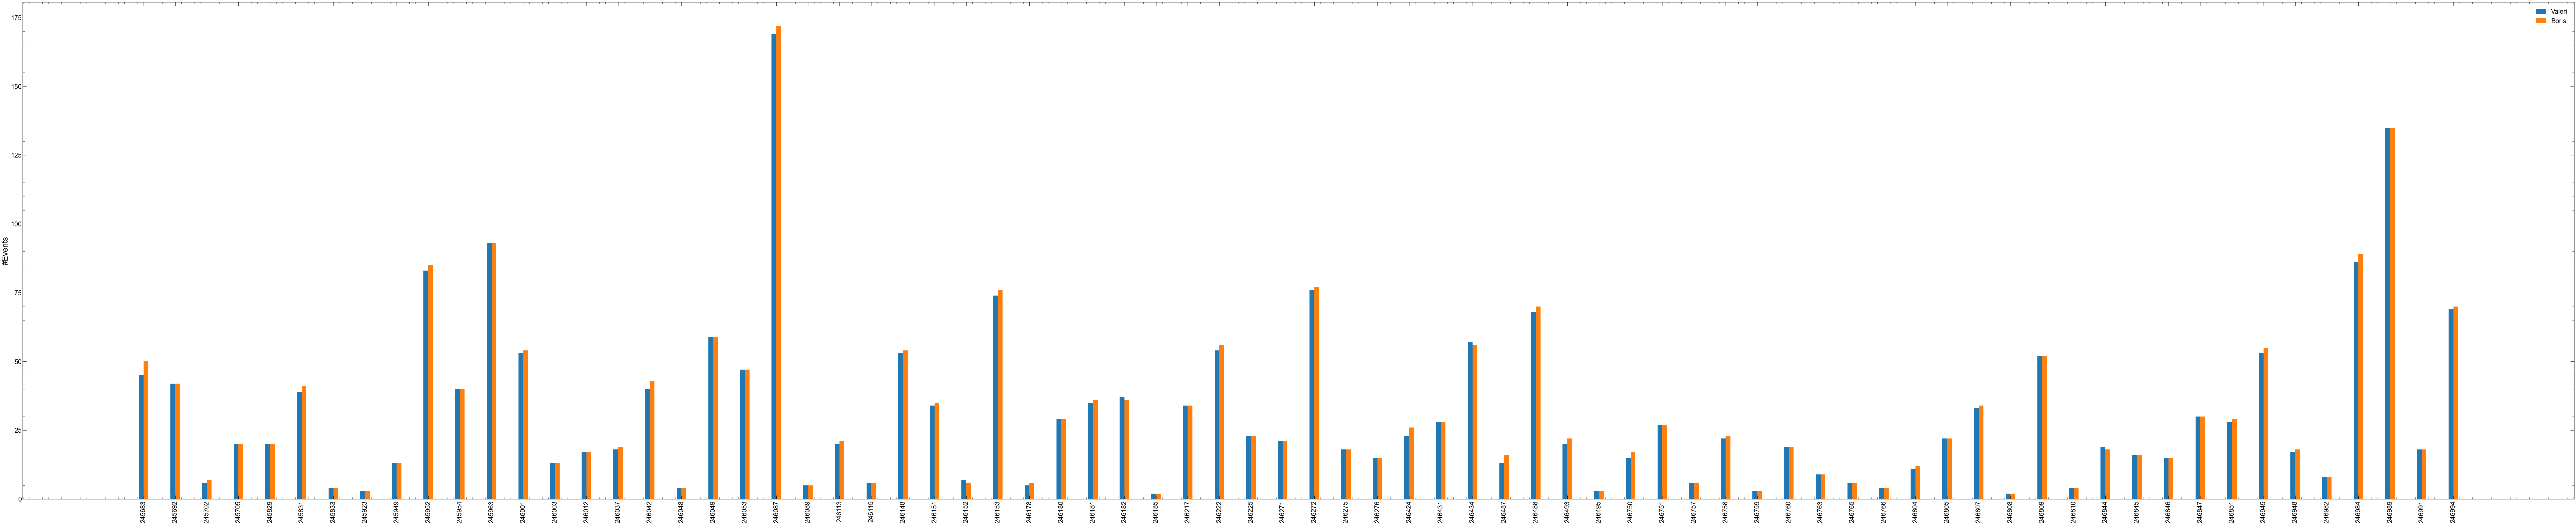

In [38]:
val = valeri['RunNum'].to_numpy(dtype=np.int)
my = myData['RunNum'].to_numpy(dtype=np.int)

print(min(val), max(val), max(val) - min(val))
print(min(my), max(my), max(my) - min(my))
totalRunNUmbers = np.unique(list(val))# + (list(my)))
valDict = {}
myDict = {}
for r in totalRunNUmbers:
    valDict[r] = 0
    myDict[r] = 0
    
for v in val:
    valDict[v] +=1
    
for v in my:
    if (v not in totalRunNUmbers):
        continue
    myDict[v] +=1
    
x = np.arange(len(totalRunNUmbers))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(150, 30))
rects1 = ax.bar(x - width/2, valDict.values(), width, label='Valeri')
rects2 = ax.bar(x + width/2, myDict.values(), width, label='Boris')
ax.set_ylabel('#Events')
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(totalRunNUmbers,rotation=90)
ax.legend()

print('Valeri good events number: ', sum(valDict.values()))
print('Boris good events number: ', sum(myDict.values()))


In [18]:
valArr = valeri.loc[:,'RunNum':'BunchCrossNumber'].to_numpy(dtype=np.int)
myArr = myData.loc[:,'RunNum':'BunchCrossNumber'].to_numpy(dtype=np.int)
valArr_rows = set(map(tuple, valArr))
myArr_rows = set(map(tuple, myArr))
print(len(valArr_rows.difference(myArr_rows)), len(myArr_rows.difference(valArr_rows)))

valArr_rows.intersection(myArr_rows)
OnlyValeri = []
for v in valArr_rows.difference(myArr_rows):
    l = list(v)
    l.append(valeri['Pt'][valeri['RunNum'] == v[0]]\
             [valeri['PeriodNumber'] == v[1]]\
             [valeri['OrbitNumber'] == v[2]]\
             [valeri['BunchCrossNumber'] == v[3]].values[0])
    OnlyValeri.append(tuple(l))

OnlyBoris = []
for v in myArr_rows.difference(valArr_rows):
    l = list(v)
    l.append(myData['Pt'][myData['RunNum'] == v[0]] \
             [myData['PeriodNumber'] == v[1]] \
             [myData['OrbitNumber'] == v[2]] \
             [myData['BunchCrossNumber'] == v[3]].values[0])
    OnlyBoris.append(tuple(l))    

2264 3


In [20]:
exist = 0
sel = []
ns = []
for n in range(len(OnlyValeri)):
#     n= 41
    inptuple = OnlyValeri[n]
#     print(n, inptuple)
    if inptuple[0] != 246222:
        continue
    evNum = np.argwhere((data['RunNum']==inptuple[0]) * \
                   (data['PeriodNumber']==inptuple[1]) * \
                   (data['OrbitNumber']==inptuple[2]) * \
                   (data['BunchCrossNumber']==inptuple[3]) \
                   ).flatten()

#   print(evNum)
    if len(evNum) > 0:
        exist += 1
        ns.append(n)
#         if (~newT_ITSsa[evNum[0]]).sum() == 4:
        print (n, evNum)
        ShowTracks(evNum[0], AllTracksInEvent=True)
print(exist)
print(ns)

4 [872]


Selected  T_Q      T_Px      T_Py        Pt      T_Pz  \
entry subentry                                                          
872   0             True   -1  0.378708 -0.134735  0.781892 -0.406578   
      1             True    1 -0.063585  0.472132  0.781892 -0.511189   
      2             True    1 -0.216257 -0.009342  0.781892 -0.163311   
      3             True   -1 -0.113412 -0.182611  0.781892 -0.234232   
      4             True    1 -0.693157  0.311416  0.781892 -0.856406   
      5             True    1  0.068494 -0.006564  0.781892 -0.066852   

                T_TPCNCls  T_ITSNCls  T_TPCRefit  T_ITSRefit  RunNum  \
entry subentry                                                         
872   0               120          4        True        True  246222   
      1               111          4        True        True  246222   
      2               133          5        True        True  246222   
      3                96          5        True        True  246222   
      4                 0          5       False        True  246222   
      5                 0          5       False       False  246222   

                PeriodNumber  OrbitNumber  BunchCrossNumber    T_Dca1  \
entry subentry                                                          
872   0                    2       510496              1728  0.150642   
      1                    2       510496              1728  0.215790   
      2                    2       510496              1728  0.160678   
      3                    2       510496              1728  0.178325   
      4                    2       510496              1728  0.211592   
      5                    2       510496              1728 -0.325863   

                  T_Dca0  T_NumberOfSigmaTPCPion  
entry subentry                                    
872   0        -0.002168                0.538319  
      1        -0.013441               -1.771695  
      2         0.033403                1.363233  
      3         0.001106                2.852491  
      4         0.130995             -999.000000  
      5        -1.145345             -999.000000

1
[4]


In [102]:
exist = 0
sel = []
ns = []
# for n in range(len(OnlyValeri)):
#     n= 41
#510496, 12874228
inptuple = (246222,2,510496,1728) 
inptuple = (246222,4,12874228,3543) 
# inptuple = (246222,4,2195909,2275) 


#     print(n, inptuple)

evNum = np.argwhere((data['RunNum']==inptuple[0]) * \
                   (data['PeriodNumber']==inptuple[1]) * \
                   (data['OrbitNumber']==inptuple[2]) * \
                   (data['BunchCrossNumber']==inptuple[3]) \
                   ).flatten()
print(evNum)
ShowTracks(evNum[0], AllTracksInEvent=True)


[10]


Selected  T_Q      T_Px      T_Py        Pt      T_Pz  \
entry subentry                                                          
10    0             True   -1  0.112298 -0.032995  0.123835  0.023403   
      1             True    1 -0.066949 -0.176824  0.123835  0.078230   
      2            False    1  0.080823  0.076158  0.123835  0.003922   
      3            False    1  0.008272  0.099235  0.123835  0.086030   
      4             True   -1 -0.021968 -0.105094  0.123835  0.121884   
      5             True    1  0.098839  0.294976  0.123835  0.267012   

                T_TPCNCls  T_ITSNCls  T_TPCRefit  T_ITSRefit  RunNum  \
entry subentry                                                         
10    0                 0          3       False        True  246222   
      1                 0          3       False        True  246222   
      2                 0          3       False       False  246222   
      3                 0          3       False       False  246222   
      4                 0          3       False        True  246222   
      5                 0          3       False        True  246222   

                PeriodNumber  OrbitNumber  BunchCrossNumber    T_Dca1  \
entry subentry                                                          
10    0                    4     12874228              3543  0.228412   
      1                    4     12874228              3543 -0.187365   
      2                    4     12874228              3543  0.461646   
      3                    4     12874228              3543 -0.280844   
      4                    4     12874228              3543 -0.149406   
      5                    4     12874228              3543 -0.483828   

                  T_Dca0  T_NumberOfSigmaTPCPion  
entry subentry                                    
10    0         0.192914                  -999.0  
      1        -1.707914                  -999.0  
      2        -0.085415                  -999.0  
      3        -1.449433                  -999.0  
      4         1.201094                  -999.0  
      5        -0.050208                  -999.0

10000